In [168]:
import sys
import os
import numpy as np
from scipy.optimize import curve_fit
import random
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pdb #python debugger
from timeit import default_timer as timer #timer
from collections import OrderedDict
import importlib
sys.path.insert(1, '/Users/ryanlopez/ABPTutorial/c++') #Connects to ABP Folder github.com/ryanlopezzzz/ABPTutorial
from cppmd.builder import *
import cppmd as md
import read_data as rd #reads snapshot text data
import directories #used to create directories for saving data
import Physical_Quantities.vorticity as vorticity
import Physical_Quantities.flocking_factors as flocking_factors
import Physical_Quantities.fourier_calculations as fc
import Physical_Quantities.various as various
importlib.reload(vorticity)
importlib.reload(fc)

<module 'Physical_Quantities.fourier_calculations' from '/Users/ryanlopez/Desktop/Python_Programs/Dr_Marchetti_Research/ABP/Physical_Quantities/fourier_calculations.py'>

In [277]:
def save_fig_pdf(base_filename, extra_label):
    save_filename = os.path.join(base_filename, extra_label)
    plt.savefig(save_filename, formate='pdf', bbox_inches='tight')

In [204]:
def edges_from_centers_linear(centers):
    """
    Returns bin edges for histogram given array of centers spaced linearly
    
    Input centers: [a, a+1*b, a+2*b, ..., a+ (n-1)*b] (linearly spaced centers)
    Output edges: [a-b/2, a+b/2, a+3b/2, ..., a+(n-1/2)*b] (linearly spaced bin edges which surround centers)
    """
    a = centers[0]
    b = centers[1]-centers[0]
    n = len(centers)
    
    edges_first_value = a-b/2
    edges_last_value = a+(n-1/2)*b
    edges_length = n+1
    
    edges = np.linspace(edges_first_value, edges_last_value, edges_length)
    return edges

def edges_from_centers_log(centers):
    """
    Returns bine edges for histogram given array of center spaced linearly
    """
    centers_log = np.log(centers)
    edges_log = edges_from_centers_linear(centers_log)
    edges = np.exp(edges_log)
    
    return edges

In [224]:
Dr_vals = np.linspace(0.4,1,4) #[1:]
J_vals = np.linspace(0,0.2,11)

print(Dr_vals)
print(J_vals)

Dr_bins = edges_from_centers_linear(Dr_vals)
J_bins = edges_from_centers_linear(J_vals)

[0.4 0.6 0.8 1. ]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


In [247]:
vicsek_values = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float) #fill with 100 so can see if an index not replaced
dir_dot_vel_values = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float)
dir_dot_vel_norm_values = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float) 
dir_cross_vel_values = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float)
dir_cross_vel_norm_values = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float) 

vicsek_dev = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float)
dir_dot_vel_dev = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float)
dir_dot_vel_norm_dev = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float) 
dir_cross_vel_dev = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float)
dir_cross_vel_norm_dev = np.full([len(Dr_vals), len(J_vals)], 100, dtype = float) 

In [257]:
#Directory where all data is saved
save_dir = "/Users/ryanlopez/Desktop/Python_Programs/Dr_Marchetti_Research/Saved_Data"
exp_folder_name = "J_Packing_Phase_Diagram" #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
image_dir = os.path.join(exp_dir, 'images')
if not os.path.isdir(image_dir):
    os.mkdir(image_dir)

for f in os.scandir(exp_dir): #runs through all immediate subdirectories
    if f.is_dir() and f.path != os.path.join(exp_dir, ".ipynb_checkpoints") and f.path != os.path.join(exp_dir, "images"):
        run_desc_file = open(os.path.join(f, 'run_desc.json'))
        run_desc = json.loads(run_desc_file.read())
        run_desc_file.close()
        
        single_stats_file = open(os.path.join(f, 'single_stats.json'))
        single_stats = json.loads(single_stats_file.read())
        single_stats_file.close()
        
        J_index = np.digitize(run_desc['J'], J_bins)-1
        Dr_index = np.digitize(run_desc['approx_packing'], Dr_bins)-1
        
        vicsek_values[Dr_index, J_index] = single_stats['vicsek_param']
        dir_dot_vel_values[Dr_index, J_index] = single_stats['dir_dot_vel']
        dir_dot_vel_norm_values[Dr_index, J_index] = single_stats['dir_dot_vel_norm']
        dir_cross_vel_values[Dr_index, J_index] = single_stats['dir_cross_vel']
        dir_cross_vel_norm_values[Dr_index, J_index] = single_stats['dir_cross_vel_norm']
        
        vicsek_dev[Dr_index, J_index] = single_stats['vicsek_param_std_dev']
        dir_dot_vel_dev[Dr_index, J_index] = single_stats['dir_dot_vel_std_dev']
        dir_dot_vel_norm_dev[Dr_index, J_index] = single_stats['dir_dot_vel_norm_std_dev']
        dir_cross_vel_dev[Dr_index, J_index] = single_stats['dir_cross_vel_std_dev']
        dir_cross_vel_norm_dev[Dr_index, J_index] = single_stats['dir_cross_vel_norm_std_dev']

In [250]:
#print(dir_dot_vel_values)
#print(dir_cross_vel_norm_values)

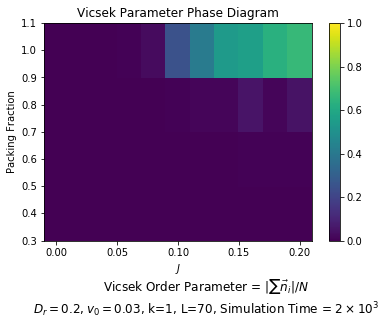

In [353]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(J_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,vicsek_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Vicsek Parameter Phase Diagram")
plt.ylabel(r'Packing Fraction')
plt.xlabel(r'$J$')

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'vicsek_phase_diagram.pdf')

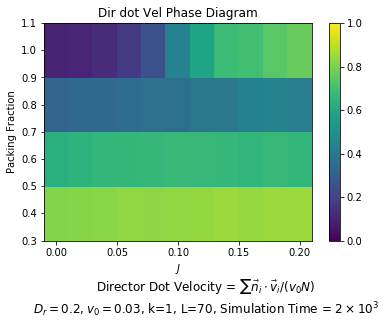

In [354]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(J_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_dot_vel_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Dir dot Vel Phase Diagram")
plt.ylabel(r'Packing Fraction')
plt.xlabel(r'$J$')

fig.text(.5, -0.05, r"Director Dot Velocity = $\sum \vec{n}_i \cdot \vec{v}_i / (v_0 N)$", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_phase_diagram.pdf')

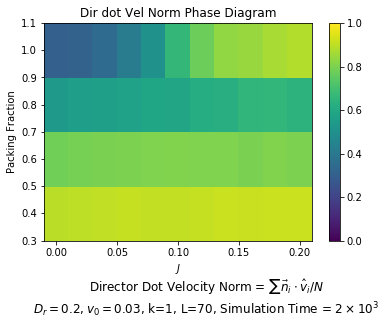

In [355]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(J_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_dot_vel_norm_values, vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Dir dot Vel Norm Phase Diagram")
plt.ylabel(r'Packing Fraction')
plt.xlabel(r'$J$')

fig.text(.5, -0.05, r"Director Dot Velocity Norm = $\sum \vec{n}_i \cdot \hat{v}_i / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_norm_phase_diagram.pdf')

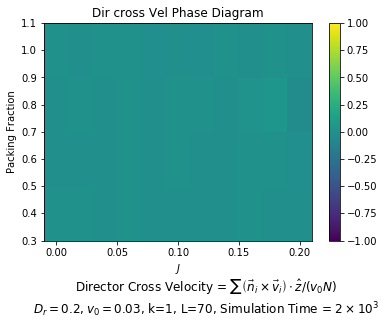

In [356]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(J_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_cross_vel_values, vmin=-1, vmax=1)
plt.colorbar(plot)
plt.title("Dir cross Vel Phase Diagram")
plt.ylabel(r'Packing Fraction')
plt.xlabel(r'$J$')

fig.text(.5, -0.05, r"Director Cross Velocity = $\sum \left(\vec{n}_i \times \vec{v}_i \right) \cdot \hat{z} / (v_0 N)$", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_cross_vel_phase_diagram.pdf')

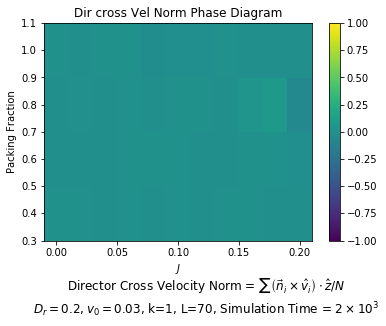

In [357]:
fig, ax = plt.subplots()
xedges, yedges = np.meshgrid(J_bins,Dr_bins)
plot = ax.pcolormesh(xedges,yedges,dir_cross_vel_norm_values, vmin=-1, vmax=1)
plt.colorbar(plot)
plt.title("Dir cross Vel Norm Phase Diagram")
plt.ylabel(r'Packing Fraction')
plt.xlabel(r'$J$')

fig.text(.5, -0.05, r"Director Cross Velocity Norm = $\sum \left(\vec{n}_i \times \hat{v}_i \right) \cdot \hat{z} / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_cross_vel_norm_phase_diagram.pdf')

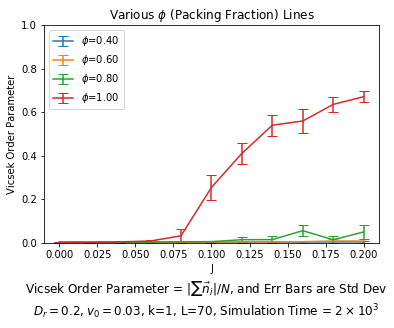

In [358]:
fig, ax = plt.subplots()
for i in range(vicsek_values.shape[0]):
    ax.errorbar(J_vals, vicsek_values[i],yerr=vicsek_dev[i],capsize=5,ms=5,label=r'$\phi$=%.2f'%Dr_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $\phi$ (Packing Fraction) Lines')
plt.xlabel('J')
plt.ylabel('Vicsek Order Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'vicsek_packing_frac_lines.pdf')

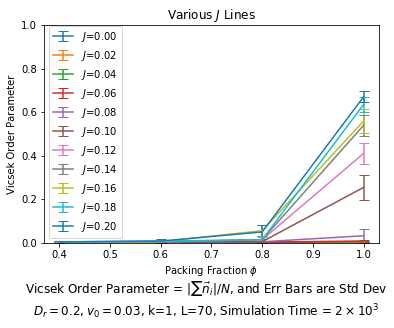

In [359]:
fig, ax = plt.subplots()
for i in range(vicsek_values.shape[1]):
    ax.errorbar(Dr_vals, vicsek_values[:,i],yerr=vicsek_dev[:,i],capsize=5,ms=5,label=r'$J$=%.2f'%J_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $J$ Lines')
plt.xlabel(r'Packing Fraction $\phi$')
plt.ylabel('Vicsek Order Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'vicsek_J_lines.pdf')

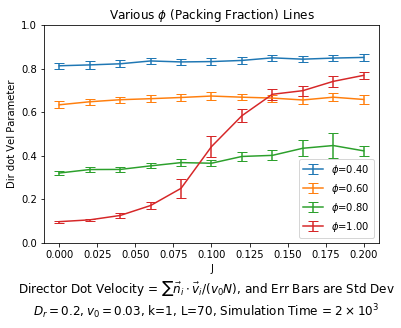

In [360]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_values.shape[0]):
    ax.errorbar(J_vals, dir_dot_vel_values[i],yerr=dir_dot_vel_dev[i],capsize=5,ms=5,label=r'$\phi$=%.2f'%Dr_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $\phi$ (Packing Fraction) Lines')
plt.xlabel('J')
plt.ylabel('Dir dot Vel Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity = $\sum \vec{n}_i \cdot \vec{v}_i / (v_0 N)$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_packing_frac_lines.pdf')

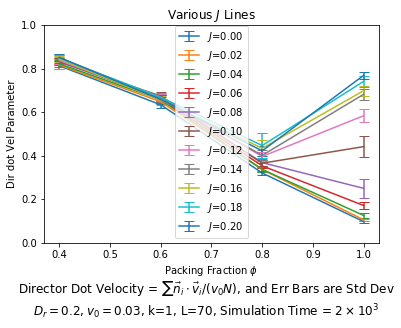

In [361]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_values.shape[1]):
    ax.errorbar(Dr_vals, dir_dot_vel_values[:,i],yerr=dir_dot_vel_dev[:,i],capsize=5,ms=5,label=r'$J$=%.2f'%J_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $J$ Lines')
plt.xlabel(r'Packing Fraction $\phi$')
plt.ylabel('Dir dot Vel Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity = $\sum \vec{n}_i \cdot \vec{v}_i / (v_0 N)$, and Err Bars are Std Dev", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_J_lines.pdf')

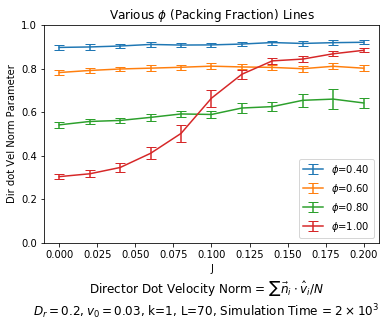

In [362]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_norm_values.shape[0]):
    ax.errorbar(J_vals, dir_dot_vel_norm_values[i],yerr=dir_dot_vel_norm_dev[i],capsize=5,ms=5,label=r'$\phi$=%.2f'%Dr_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $\phi$ (Packing Fraction) Lines')
plt.xlabel('J')
plt.ylabel('Dir dot Vel Norm Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity Norm = $\sum \vec{n}_i \cdot \hat{v}_i / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_norm_packing_frac_lines.pdf')

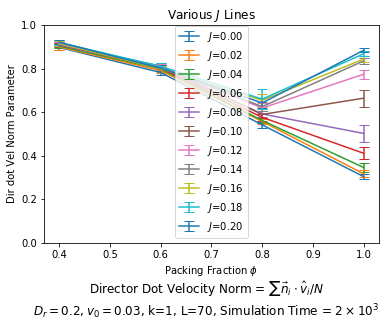

In [363]:
fig, ax = plt.subplots()
for i in range(dir_dot_vel_norm_values.shape[1]):
    ax.errorbar(Dr_vals, dir_dot_vel_norm_values[:,i],yerr=dir_dot_vel_norm_dev[:,i],capsize=5,ms=5,label=r'$J$=%.2f'%J_vals[i])
    
ax.set_ylim(0,1)
plt.title(r'Various $J$ Lines')
plt.xlabel(r'Packing Fraction $\phi$')
plt.ylabel('Dir dot Vel Norm Parameter')
#plt.yscale('log')
plt.legend()

fig.text(.5, -0.05, r"Director Dot Velocity Norm = $\sum \vec{n}_i \cdot \hat{v}_i / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, r"$D_r= 0.2, v_0 = 0.03$, k=1, L=70, Simulation Time = $2 \times 10^{3}$", ha='center', fontsize=12)

save_fig_pdf(image_dir, 'dir_dot_vel_norm_J_lines.pdf')

Text(0.5, 0, 'time')

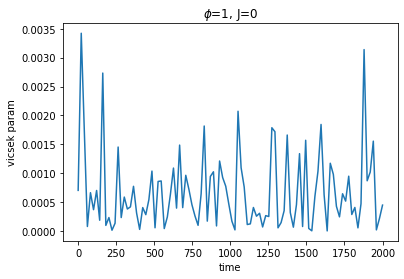

In [69]:
tf = 2e3
total_snapshots = 100

times = np.linspace(0,tf,total_snapshots)

snapshot_dir = os.path.join(exp_dir, 'J=0.0000_and_packing=1.0002/', "snapshot_data/")

exp_data = rd.get_exp_data(snapshot_dir)
vicsek_param, vel_param = flocking_factors.get_flocking_factors(exp_data, 0.03)
plt.plot(times,vicsek_param)
plt.title(r'$\phi$=1, J=0')
plt.ylabel('vicsek param')
plt.xlabel('time')

Text(0.5, 0, 'time')

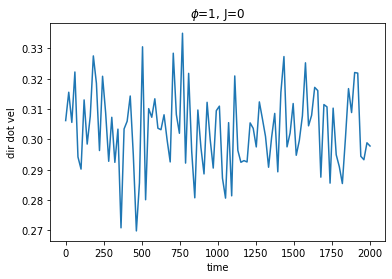

In [70]:
tf = 2e3
total_snapshots = 100

times = np.linspace(0,tf,total_snapshots)

run_dir = os.path.join(exp_dir, 'J=0.0000_and_packing=1.0002/')
dir_dot_vel = np.load(os.path.join(run_dir, "dir_dot_vel_norm.npy"))

plt.plot(times,dir_dot_vel)
plt.title(r'$\phi$=1, J=0')
plt.ylabel('dir dot vel')
plt.xlabel('time')

